# Intro to Object Detection Colab

Welcome to the object detection colab! This demo will take you through the steps of running an "out-of-the-box" detection model in SavedModel format on a collection of images.



# Mount your Google Drive

Imports

In [ ]:
%cd /content/
!mkdir workspace
%cd /content/workspace
!mkdir test_images
!mkdir pre-trained-models

/content
/content/workspace


In [ ]:
#!pip install -U --pre tensorflow=="2.2.0"

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2922, done.
remote: Counting objects: 100% (2922/2922), done.
remote: Compressing objects: 100% (2455/2455), done.
remote: Total 2922 (delta 742), reused 1251 (delta 429), pack-reused 0
Receiving objects: 100% (2922/2922), 32.98 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (742/742), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/workspace/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1665627 sha256=f64dd4b10b110f08b0ca03ee0026e8c98da13adde8ba61c90b41d92dbab886d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ev61eyoi/wheels/c6/17/fa/c9f5a5514e215f989a46cfee094cd0f436136322c48a0d6ecd
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=6a113dbc0b7c124116b59dd4897a78ed0fc2f22112f38a1200c3b82443275832
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=d41f1885305fab1c584f95eaf3af24944da7f53b68792ec91b3ae0c01bea38bb
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=7177addb1d783431c023e05ee4f79781835b491

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)



In [ ]:
# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [ ]:
# Download the saved model and put it into models/research/object_detection/test_data/
%cd /content/workspace/pre-trained-models/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz


/content/workspace/pre-trained-models
--2021-09-26 12:08:27--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.133.128, 2a00:1450:400c:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.133.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256286417 (244M) [application/x-tar]
Saving to: ‘efficientdet_d5_coco17_tpu-32.tar.gz’

efficientdet_d5_coc 100%[===================>] 244.41M   124MB/s    in 2.0s    

2021-09-26 12:08:29 (124 MB/s) - ‘efficientdet_d5_coco17_tpu-32.tar.gz’ saved [256286417/256286417]



In [ ]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/content/workspace/pre-trained-models/efficientdet_d5_coco17_tpu-32/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 98.05195331573486s


images.jpeg


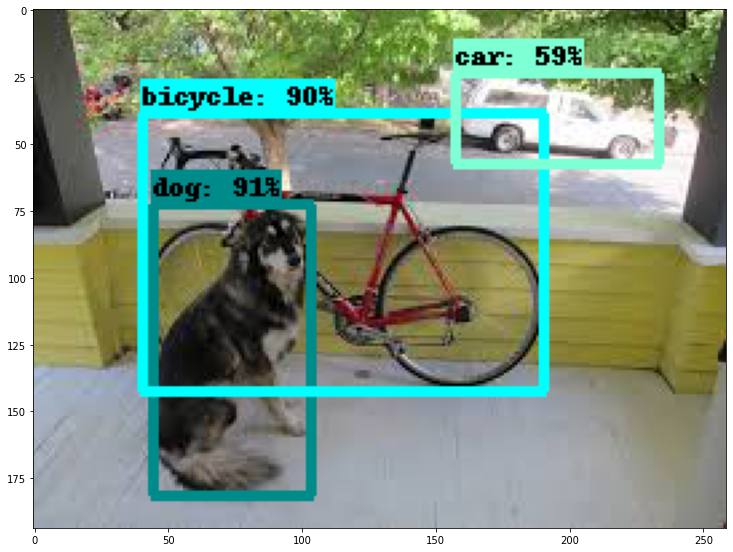

In [ ]:
import time
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

image_dir = '/content/workspace/test_images'
file_names = os.listdir(image_dir)

elapsed = []

for name in file_names:
  print(name)
  if name.endswith('.jpeg') or name.endswith('.jpg') or name.endswith('.png'):
        image_path = os.path.join(image_dir, name)
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = np.expand_dims(image_np, 0)
        start_time = time.time()
        detections = detect_fn(input_tensor)
        end_time = time.time()
        elapsed.append(end_time - start_time)

        plt.rcParams['figure.figsize'] = [42, 21]
        label_id_offset = 1
        image_np_with_detections = image_np.copy()
        
        viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'][0].numpy(),
              detections['detection_classes'][0].numpy().astype(np.int32),
              detections['detection_scores'][0].numpy(),
              category_index,#
              use_normalized_coordinates=True,
              max_boxes_to_draw=200,
              min_score_thresh=.40,
              agnostic_mode=False)
        plt.subplot(2, 1, len(file_names)+1)
        plt.imshow(image_np_with_detections)

#mean_elapsed = sum(elapsed) / float(len(elapsed))
#print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

# Exercice: 
Write a script that will apply inference to a sample of X images and measure inference time. Plot a graph of X when X varies from 10 to 100 by increments of 10.